In [1]:
%matplotlib inline
import rasterio
# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd

from datacube.utils import geometry

import pyproj
import pystac_client

from shapely.geometry import box
from shapely.ops import transform

import odc.stac
from odc.geo.geobox import GeoBox


In [46]:
!ls

01_Exploring_Products.ipynb			05_Aggregation.ipynb
02_Loading_Data_to_Xarrays.ipynb		06_Working_with_Vectors.ipynb
03_Plotting.ipynb				demo_eurocrops.geojson
04_Using_Indices_in_a_Real_World_Example.ipynb	parcels_2020_italy.json


In [2]:
shp = 'demo_eurocrops.geojson'

In [3]:
gdf = gpd.read_file(shp)
gdf.head()

,recno,crpname,crpgrpc,crpgrpn,NUTS_NAME,org_id,borderParc,use,r1,az_id_org,NUTS_ID,country,geometry
0,463,ACKERBOHNEN (PUFFBOHNEN),33111022,leguminous_plants,Nordburgenland,463,0,training,1000462,1,AT112,austria,"MULTIPOLYGON (((16.4238 47.82078, 16.42302 47...."
1,464,ACKERBOHNEN (PUFFBOHNEN),33111022,leguminous_plants,Nordburgenland,464,0,training,1000463,1,AT112,austria,"MULTIPOLYGON (((16.4207 47.82809, 16.42025 47...."
2,504,ACKERBOHNEN (PUFFBOHNEN),33111022,leguminous_plants,Nordburgenland,504,0,training,1000503,1,AT112,austria,"MULTIPOLYGON (((16.31004 47.80296, 16.30982 47..."
3,577,ACKERBOHNEN (PUFFBOHNEN),33111022,leguminous_plants,Nordburgenland,577,0,training,1000576,1,AT112,austria,"MULTIPOLYGON (((16.40648 47.79812, 16.40639 47..."
4,578,ACKERBOHNEN (PUFFBOHNEN),33111022,leguminous_plants,Nordburgenland,578,0,training,1000577,1,AT112,austria,"MULTIPOLYGON (((16.4066 47.78727, 16.40639 47...."


In [4]:
gdf.shape

(6331, 13)

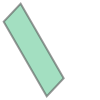

In [26]:
gdf.geometry[24]

In [28]:
unique_labels = np.unique(gdf.crpgrpn)
unique_labels

array(['arable_land_seed_and_seedlings',
       'aromatic_plants_medicinal_and_culinary_plants', 'cucurbits',
       'fresh_vegetables_melons_and_strawberries',
       'fruit_of_temperate_climate_zones', 'grain_maize',
       'leguminous_plants', 'millet', 'not_known', 'nuts',
       'other_cereals_for_the_production_of_grain',
       'other_industrial_crops_not_mentioned_elsewhere',
       'other_oil_seed_crops', 'other_plants_harvested_green', 'others',
       'pasture_meadow', 'potatoes', 'soya', 'sugar_beet',
       'summer_barley', 'summer_common_wheat_and_spelt',
       'summer_durum_wheat', 'summer_oats',
       'sunflower_and_yellow_bloomer', 'vineyards', 'winter_barley',
       'winter_common_wheat_and_spelt', 'winter_durum_wheat',
       'winter_rape', 'winter_rye', 'winter_triticale'], dtype=object)

In [25]:
# Dictionary to save results 
parcels = {}

# A progress indicator
i = 0
maxArea = -1

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    geom = geometry.Geometry(row.geometry.__geo_interface__,geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))
    if geom.area > maxArea:
        maxArea  = geom.area
        selected_geom = geom

In [6]:
maxArea

4.1087630380013205e-05

In [29]:
### Geometry Mask Module

def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [8]:
from shapely import wkt

# Convert WKT string to a Shapely Polygon object
polygon = wkt.loads(selected_geom.wkt)
# Extract the bounds
xmin, ymin, xmax, ymax = polygon.bounds

In [9]:

# STAC connection information for Sentinel 2 COGs
STAC_URL = "https://earth-search.aws.element84.com/v0"
STAC_COLLECTION = "sentinel-s2-l2a-cogs"

# spatial projection information
CRS_STRING = "epsg:4326"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()

AOI = box(xmin,ymin,xmax,ymax)
bounds = (xmin,ymin,xmax,ymax)
# BANDS = ["B04", "B03", "B02"]
START_DATE = "2023-01-01"
END_DATE = "2023-12-31"

# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
bbox_4326 = transform(transformer_4326.transform, AOI).bounds

catalog = pystac_client.Client.open(STAC_URL)
catalog.add_conforms_to("ITEM_SEARCH")

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
    query={"eo:cloud_cover": {"lt": 50}}
)#.item_collection()

# using Open Data Cube stac component
dx = 3/3600  # ~90m resolution
dx = 20 / 111320 # ~20m res
epsg = 4326
geobox = GeoBox.from_bbox(bounds, crs=f"epsg:{epsg}", resolution=dx)

data = odc.stac.load(
    stac_items.items(),
    chunks={},
    geobox=geobox,
    bands=["B02","B03","B04"],
    resampling="bilinear",
    groupby="solar_day" # delete duplicates due to satellite overlap
)

/home/agriusr/miniconda3/envs/odc/lib/python3.12/site-packages/pystac_client/client.py:190: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())
/home/agriusr/miniconda3/envs/odc/lib/python3.12/site-packages/pystac_client/item_search.py:372: DoesNotConformTo: Server does not conform to QUERY
  warnings.warn(DoesNotConformTo("QUERY"))


In [10]:
mask = geometry_mask([selected_geom], data.geobox, invert=True)
masked_data = data.where(mask)

In [11]:
masked_data = masked_data.load()

/home/agriusr/miniconda3/envs/odc/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [15]:
masked_data

<xarray.Dataset> Size: 518kB
Dimensions:      (time: 23, latitude: 39, longitude: 48)
Coordinates:
  * latitude     (latitude) float64 312B 47.81 47.81 47.81 ... 47.8 47.8 47.8
  * longitude    (longitude) float64 384B 16.42 16.42 16.42 ... 16.43 16.43
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 184B 2023-01-07T09:57:17 ... 2023-04-3...
Data variables:
    B02          (time, latitude, longitude) float32 172kB nan nan ... nan nan
    B03          (time, latitude, longitude) float32 172kB nan nan ... nan nan
    B04          (time, latitude, longitude) float32 172kB nan nan ... nan nan

In [17]:
monthly_data = masked_data.resample(time='1M').mean()

# Calculate the mean of all pixels for each monthly period
monthly_mean = monthly_data.mean(dim=['latitude', 'longitude'])

In [18]:
monthly_mean

<xarray.Dataset> Size: 84B
Dimensions:      (time: 4)
Coordinates:
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 32B 2023-01-31 2023-02-28 ... 2023-04-30
Data variables:
    B02          (time) float32 16B 1.863e+03 4.459e+03 4.798e+03 2.511e+03
    B03          (time) float32 16B 1.733e+03 4.252e+03 4.562e+03 2.489e+03
    B04          (time) float32 16B 1.714e+03 4.21e+03 4.507e+03 2.533e+03